In [1]:
from pdfminer.pdfinterp import PDFResourceManager, process_pdf
from pdfminer.converter import TextConverter
from pdfminer.layout import LAParams
from io import StringIO
from io import open
from urllib.request import urlopen
import re
import os

In [2]:
def read_pdf_file(pdfFile):
    pdfrm = PDFResourceManager()
    strio = StringIO()
    lapa = LAParams()
    device = TextConverter(pdfrm, strio, laparams = lapa)
    
    process_pdf(pdfrm, device, pdfFile)
    device.close()
    
    content = strio.getvalue()
    strio.close()
    return content

In [5]:
pdf_CJD_AABA= open("ESG/CJ대한통운.pdf", "rb")
CJD_AABA = read_pdf_file(pdf_CJD_AABA)
pdf_CJD_AABA.close()

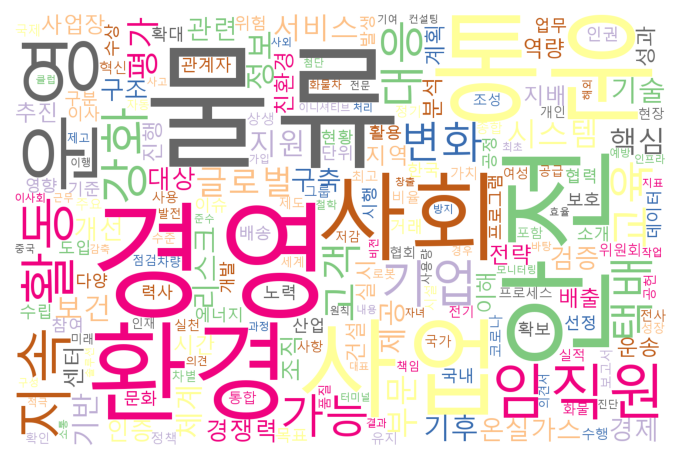

In [13]:
from konlpy.tag import Mecab
mecab = Mecab()
stop = ["삼성", "디스플레이", "관리"]
CJD_AABA_tokens = [token for token in mecab.pos(CJD_AABA)]

CJD_AABA_nodes = [t[0] for t in CJD_AABA_tokens]
CJD_AABA_vocab = [t[0] for t in CJD_AABA_tokens if t[0] not in stop if t[1] in ['NNG', 'NNP'] and len(t[0]) > 1]

import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter

count = Counter(CJD_AABA_vocab)
words = dict(count.most_common())

%matplotlib inline 
import matplotlib 
from IPython.display import set_matplotlib_formats 
matplotlib.rc('font',family = 'Malgun Gothic') 
set_matplotlib_formats('retina') 
matplotlib.rc('axes',unicode_minus = False)

wordcloud = WordCloud(font_path = 'C:/Windows/Fonts/malgun.ttf', background_color='white',colormap = "Accent_r", 
                      width=1500, height=1000).generate_from_frequencies(words) 
plt.imshow(wordcloud) 
plt.axis('off') 
plt.show()

In [12]:
CJD_AABA_vocab = list(set(vocab))

vocab2idx = {vocab[i]:i for i in range(len(vocab))}
idx2vocab = {i:vocab[i] for i in range(len(vocab))}

import numpy as np
import math

vocab_len = len(vocab2idx)

# 토큰별로 그래프 edge를 Matrix 형태로 생성
weighted_edge = np.zeros((vocab_len,vocab_len),dtype=np.float32)

# 각 토큰 노드별로 스코어 1로 초기화
score = np.ones((vocab_len),dtype=np.float32)

# coocurrence를 판단하기 위한 window 사이즈 설정
window_size = 4
covered_coocurrences = []

for window_start in range(len(nodes) - window_size + 1):
    window = nodes[window_start:window_start+window_size]
    for i in range(window_size):
        for j in range(i+1, window_size):
            if window[i] in vocab and window[j] in vocab:
                index_i = window_start + i
                index_j = window_start + j

                if (index_i, index_j) not in covered_coocurrences:
                    weighted_edge[vocab2idx[window[i]]][vocab2idx[window[j]]] = 1
                    weighted_edge[vocab2idx[window[j]]][vocab2idx[window[i]]] = 1
                    covered_coocurrences.append((index_i, index_j))

for i in range(vocab_len):
    row_sum = weighted_edge[i].sum()
    weighted_edge[i] = weighted_edge[i]/row_sum if row_sum > 0 else 0

MAX_ITERATIONS = 50
d=0.85
threshold = 0.0001 #convergence threshold

for iter in range(MAX_ITERATIONS):
    prev_score = np.copy(score)

    for i in range(vocab_len):
        summation = 0
        for j in range(vocab_len):
            if weighted_edge[j][i] != 0:
                summation += weighted_edge[j][i] * prev_score[j]

        score[i] = (1 - d) * d*summation

    if np.sum(np.fabs(prev_score -  score)) <= threshold:
        break


sorted_index = np.flip(np.argsort(score), 0)

n = 10


print("\n=== 핵심키워드 ===")
for i in range(0,n):
    print(str(idx2vocab[sorted_index[i]])+" : " + str(score[sorted_index[i]]))


=== 핵심키워드 ===
물류 : 2.7382958e-08
안전 : 2.0278028e-08
사업 : 1.9699606e-08
통운 : 1.9139021e-08
경영 : 1.7883327e-08
운영 : 1.7021708e-08
에서 : 1.6398163e-08
기업 : 1.507291e-08
임직원 : 1.4997198e-08
택배 : 1.4902271e-08


['경영', '글로벌', '기업', '물류', '사업', '안전', '에서', '운영', '임직원', '지원', '택배', '통운', '평가', '환경', '활동']
Topic 0 [('활동', 0.470999061727075, 3), ('에서', 0.43737256638548405, 3), ('안전', 0.284707270676104, 3)]
Topic 1 [('글로벌', 0.5554798787206738, 3), ('지원', 0.5159028015496436, 3), ('사업', 0.16949491457048887, 3)]
Topic 2 [('기업', 0.7654835199569823, 3), ('사업', 0.2553090071298942, 3), ('에서', 0.16208796225434252, 3)]


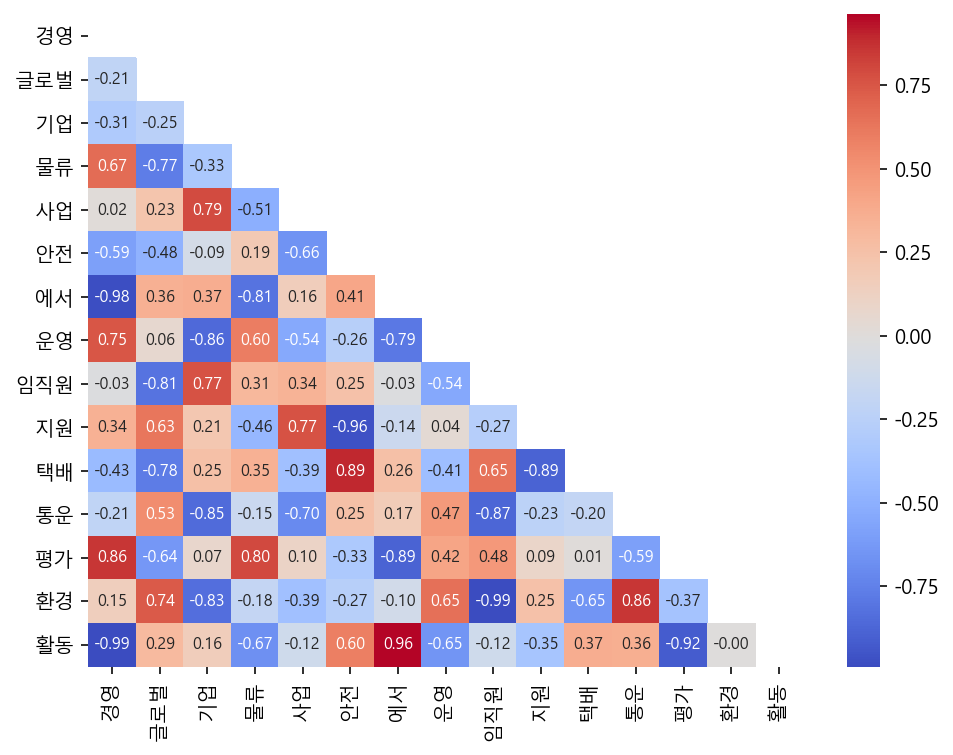

In [10]:
keyword = []
for i in range(0,15):
    keyword.append(str(idx2vocab[sorted_index[i]]))

    
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

n_topic = 3

tfidf_vect = TfidfVectorizer()
tfidf = tfidf_vect.fit_transform(keyword)
svd = TruncatedSVD(n_components=n_topic, n_iter=100)

U = svd.fit_transform(tfidf)
Vt = svd.components_


vocab = tfidf_vect.get_feature_names()
print(vocab)
n = 3
for i, topic in enumerate(Vt):
    print("Topic {}".format(i), [ (vocab[i], topic[i], round(3)) for i in topic.argsort()[:-n-1:-1]])


import numpy as np
from numpy import dot
from numpy.linalg import norm

def calc_simiarlty_matrix(vectors):
    def consine_similarity(a,b):
        return dot(a,b)/(norm(a)*norm(b))
    
    n_word = len(vectors)
    similarity_matrix = np.zeros((n_word, n_word))
    
    for i in range(n_word):
        for j in range(n_word):
            similarity_matrix[j, i] = consine_similarity(vectors[i], vectors[j]).round(4)

    return similarity_matrix

word_vectors = Vt.T
word_similarity_matrix = calc_simiarlty_matrix(word_vectors)

import matplotlib.pyplot as plt
import seaborn as sns

def visualize_similarity(similarity_matrix, label):
    mask = np.triu(np.ones_like(similarity_matrix, dtype=np.bool))
    plt.rcParams['figure.figsize'] = [8, 6]
    plt.rc('font', family='Malgun Gothic')
    ax = sns.heatmap(similarity_matrix, mask=mask, xticklabels=label, yticklabels=label,
                     annot=True, fmt=".2f", annot_kws={"size":8},cmap="coolwarm")

visualize_similarity(word_similarity_matrix, vocab)